# Use Case: Timeseries Forecasting - Air Passengers



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

## Load Dataset
The Air Passengers dataset is available in seaborn library.

In [ ]:
flights = sns.load_dataset('flights')
flights.head()

,year,month,passengers
0,1949,Jan,112
1,1949,Feb,118
2,1949,Mar,132
3,1949,Apr,129
4,1949,May,121


In [ ]:
# Map month names to numbers
month_map = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6,
             'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}
df= flights.copy()
df['month'] = df['month'].map(month_map)

# Create date from year and month
df['date'] = pd.to_datetime(df[['year', 'month']].assign(DAY=1))

# Drop the original year and month columns
df = df.drop(['year', 'month'], axis=1)

# Set the date as index
df = df.set_index('date')
df.head()

,passengers
date,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


## Exploratory Data Analysis (EDA)
Before applying any model, you need to understand the data.

Text(0.5, 1.0, 'Number of Passengers Over Time')

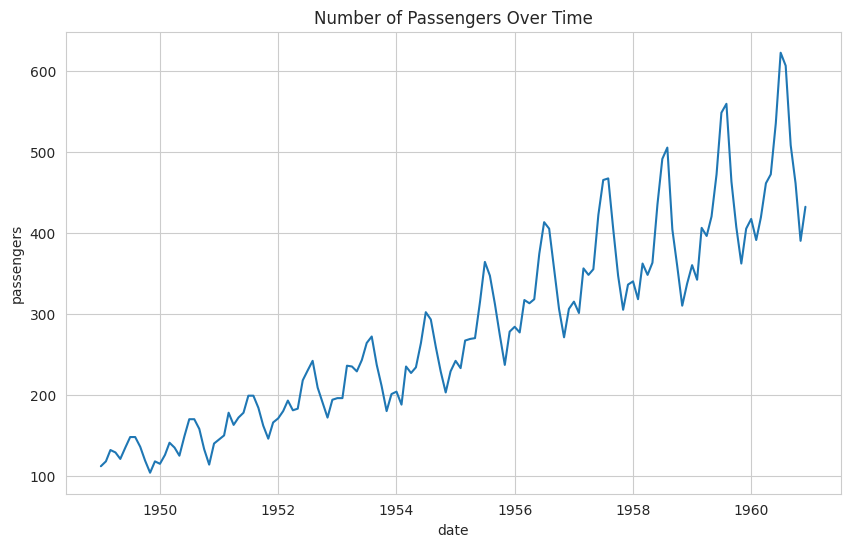

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting the data
plt.figure(figsize=(10,6))
sns.lineplot(data=df, x="date", y="passengers")
plt.title('Number of Passengers Over Time')

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(df)

In [ ]:
df_scaled


array([[0.01544402],
       [0.02702703],
       [0.05405405],
       [0.04826255],
       [0.03281853],
       [0.05984556],
       [0.08494208],
       [0.08494208],
       [0.06177606],
       [0.02895753],
       [0.        ],
       [0.02702703],
       [0.02123552],
       [0.04247104],
       [0.07142857],
       [0.05984556],
       [0.04054054],
       [0.08687259],
       [0.12741313],
       [0.12741313],
       [0.1042471 ],
       [0.05598456],
       [0.01930502],
       [0.06949807],
       [0.07915058],
       [0.08880309],
       [0.14285714],
       [0.11389961],
       [0.13127413],
       [0.14285714],
       [0.18339768],
       [0.18339768],
       [0.15444015],
       [0.11196911],
       [0.08108108],
       [0.11969112],
       [0.12934363],
       [0.14671815],
       [0.17181467],
       [0.14864865],
       [0.15250965],
       [0.22007722],
       [0.24324324],
       [0.26640927],
       [0.2027027 ],
       [0.16795367],
       [0.13127413],
       [0.173

In [ ]:
from sklearn.model_selection import train_test_split

# Create sequences for LSTM
def create_sequences(data, seq_length):
    xs = []
    ys = []

    for i in range(len(data)-seq_length-1):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)

seq_length = 5
X, y = create_sequences(df_scaled, seq_length)

# Split the data into training and testing sets
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape input to be [samples, time steps, features]
train_X = np.reshape(train_X, (train_X.shape[0], seq_length, 1))
test_X = np.reshape(test_X, (test_X.shape[0], seq_length, 1))

In [ ]:
# Note: For LSTM, you need to prepare your data accordingly. LSTM expects the input data in a specific 3D format of [samples, time steps, features].

from keras.models import Sequential
from keras.layers import LSTM, Dense

# Define LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(50, activation='relu', input_shape=(train_X.shape[1], 1)))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer='adam', loss='mse')

# Fit model
model_lstm.fit(train_X, train_y, epochs=200, verbose=0)

# Make predictions
lstm_predictions_scaled = model_lstm.predict(test_X)


1/1 [==============================] - 0s 117ms/step


In [ ]:
from statsmodels.tsa.arima.model import ARIMA

# Define ARIMA model (p,d,q) where p = periods taken for autoregressive model
# d -> Integrated order, difference
# q periods in moving average model
model_arima = ARIMA(df, order=(5,1,0))
model_arima_fit = model_arima.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Define Holt-Winters model
model_hw = ExponentialSmoothing(df, trend="add", seasonal="add", seasonal_periods=12)
model_hw_fit = model_hw.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [ ]:
from sklearn.linear_model import LinearRegression

# Prepare data for linear regression
X = [i for i in range(0, len(df))]
X = np.reshape(X, (len(X), 1))
y = df.values

# Define Linear Regression model
model_lr = LinearRegression()
model_lr.fit(X, y)

LinearRegression()

In [ ]:
# ARIMA predictions
arima_predictions = model_arima_fit.forecast(steps=len(test_X))[0]

# Holt-Winters predictions
hw_predictions = model_hw_fit.forecast(steps=len(test_X))

# Linear Regression predictions
lr_predictions = model_lr.predict(X.reshape(-1,1))

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt

# Assuming the variables lstm_predictions, arima_predictions,
# hw_predictions, and lr_predictions contain the predictions from LSTM, ARIMA,
# Holt-Winters, and Linear Regression models respectively,
# and test_y contains the actual values.

# Calculate errors for LSTM
lstm_predictions= lstm_predictions_scaled
lstm_mae = mean_absolute_error(test_y, lstm_predictions)
lstm_mse = mean_squared_error(test_y, lstm_predictions)
lstm_rmse = sqrt(lstm_mse)

# Calculate errors for ARIMA
arima_mae = mean_absolute_error(test_y, arima_predictions)
arima_mse = mean_squared_error(test_y, arima_predictions)
arima_rmse = sqrt(arima_mse)

# Calculate errors for Holt-Winters
hw_mae = mean_absolute_error(test_y, hw_predictions)
hw_mse = mean_squared_error(test_y, hw_predictions)
hw_rmse = sqrt(hw_mse)

# Calculate errors for Linear Regression
lr_mae = mean_absolute_error(test_y, lr_predictions)
lr_mse = mean_squared_error(test_y, lr_predictions)
lr_rmse = sqrt(lr_mse)

# Print errors
print('LSTM Errors: MAE =', lstm_mae, ', MSE =', lstm_mse, ', RMSE =', lstm_rmse)
print('ARIMA Errors: MAE =', arima_mae, ', MSE =', arima_mse, ', RMSE =', arima_rmse)
print('Holt-Winters Errors: MAE =', hw_mae, ', MSE =', hw_mse, ', RMSE =', hw_rmse)
print('Linear Regression Errors: MAE =', lr_mae, ', MSE =', lr_mse, ', RMSE =', lr_rmse)

TypeError: ignored